### Homework Assignment for Graduate Course in Healthcare Analytics
- Using DE-SynPUF files downloaded from https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.html
- Assignment: use methods related to decision trees to predict depression as response/target

## Initial Plan
- 
### Data Transformation
- delete patients that have duplicate columns (excluding year)
- only keep first patient record with intial depression diagnosis, reasoning is that once patitent is diagonised with
  depression, any future diagnosis would not be a predictor/cause of depression
- combine patients with multiple records in a single year so we have at most one row for each patient per year
- calc and add age column
- change/enocde values in applicable columns to 0 for no and 1 for yes</br>
### EDA
- use seaborn/matplotlib to perform intial data analysis
### Apply Model
- assignment is to use decision tree/randome forest type methods
### Feature Reduction
- assignment allows removal of two columns, determine which features, if any, can be removed
### How do we judge our model?

In [70]:
# import and read file, use NaN for elements with no values
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 

df = pd.read_csv("combined_ben_sum_AddYear.csv", na_values = ['no info', '.'])
#print(df.head(5))

In [71]:
df.shape
print(df.columns)

Index(['Year', 'DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_DEATH_DT',
       'BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_ESRD_IND', 'SP_STATE_CODE',
       'BENE_COUNTY_CD', 'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
       'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
       'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
       'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'],
      dtype='object')


In [72]:
#subset of data needed to answer assignment question #4
newdf = df[['DESYNPUF_ID','Year','BENE_BIRTH_DT','BENE_SEX_IDENT_CD','BENE_RACE_CD',
            'BENE_ESRD_IND','SP_STATE_CODE','BENE_COUNTY_CD','SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD','SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA']]
#print(newdf.head(5))

In [73]:
newdf.shape

(6873274, 19)

In [74]:
#newdf.info()

# Data Transformation

In [75]:
# checking to see how many duplicate rows, all columns except year
# don't want to skew results if have same patient over 2008-2010 with same conditions repeated each year
# only want to include if patient has developed new conditions
dup_df = newdf[newdf.duplicated(['DESYNPUF_ID','BENE_BIRTH_DT','BENE_SEX_IDENT_CD','BENE_RACE_CD',
            'BENE_ESRD_IND','SP_STATE_CODE','BENE_COUNTY_CD','SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD','SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA']) == True].sort_values(by='DESYNPUF_ID')

In [76]:
#display(dup_df)
dup_df.shape

(1424410, 19)

In [77]:
# removing duplicate rows, 1424410 removed
df_no_dup_records_1 = newdf.drop_duplicates(['DESYNPUF_ID','BENE_BIRTH_DT','BENE_SEX_IDENT_CD','BENE_RACE_CD',
            'BENE_ESRD_IND','SP_STATE_CODE','BENE_COUNTY_CD','SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD','SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA'], keep='first')

In [78]:
df_no_dup_records_1.shape

(5448864, 19)

In [79]:
# also remove all recorcds after patient's first diagnosis, any future conditions post-depression diagnosis would not be a 
# predictor or cause of depression
df_no_dup_records = df_no_dup_records_1.drop_duplicates(['DESYNPUF_ID','BENE_BIRTH_DT','SP_DEPRESSN'], keep='first')

In [80]:
#  2,291,711‬ rows removed
df_no_dup_records.shape

(3157153, 19)

In [81]:
#calculate age (year column - year from BENE_BIRTH_DT)
#newdf["Birth_Year"] = pd.to_datetime(newdf['BENE_BIRTH_DT']).dt.year
df_no_dup_records.loc[:,'Age'] = df_no_dup_records.loc[:,'Year'] - (pd.to_datetime(newdf.loc[:,'BENE_BIRTH_DT'],format='%Y%m%d').dt.year)

In [82]:
#display and check age calculation working as expected
display(df_no_dup_records.head(5))

,DESYNPUF_ID,Year,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,Age
0,00013D2EFD8E45D1,2008,19230501,1,1,0,26,950,2,2,2,2,2,2,2,2,2,2,2,85.0
1,00016F745862898F,2008,19430101,1,1,0,39,230,2,2,2,2,2,2,2,2,2,2,2,65.0
2,0001FDD721E223DC,2008,19360901,2,1,0,39,280,2,2,2,2,2,2,2,2,2,2,2,72.0
3,00021CA6FF03E670,2008,19410601,1,5,0,6,290,2,2,2,2,2,2,2,2,2,2,2,67.0
4,00024B3D2352D2D0,2008,19360801,1,1,0,52,590,2,2,2,2,2,2,2,2,1,2,2,72.0


In [83]:
# checking for any patients with multiple recods in one year (should only have one patient summary per year)
df_dup_record_year = df_no_dup_records[df_no_dup_records.duplicated(['DESYNPUF_ID','Year']) == True].sort_values(by='DESYNPUF_ID')

In [84]:
df_dup_record_year.shape
# returned 0 rows so we don't have any rows with duplicate patient ID and year

(0, 20)

In [85]:
# checking for any null values that may need transforming
df_dup_record_year.isnull()
# returned 0

,DESYNPUF_ID,Year,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,Age


In [86]:
display(df_no_dup_records.head(5))

,DESYNPUF_ID,Year,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,Age
0,00013D2EFD8E45D1,2008,19230501,1,1,0,26,950,2,2,2,2,2,2,2,2,2,2,2,85.0
1,00016F745862898F,2008,19430101,1,1,0,39,230,2,2,2,2,2,2,2,2,2,2,2,65.0
2,0001FDD721E223DC,2008,19360901,2,1,0,39,280,2,2,2,2,2,2,2,2,2,2,2,72.0
3,00021CA6FF03E670,2008,19410601,1,5,0,6,290,2,2,2,2,2,2,2,2,2,2,2,67.0
4,00024B3D2352D2D0,2008,19360801,1,1,0,52,590,2,2,2,2,2,2,2,2,1,2,2,72.0


In [87]:
print(df_no_dup_records.columns)

Index(['DESYNPUF_ID', 'Year', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD',
       'BENE_RACE_CD', 'BENE_ESRD_IND', 'SP_STATE_CODE', 'BENE_COUNTY_CD',
       'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
       'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA',
       'SP_STRKETIA', 'Age'],
      dtype='object')


In [88]:
# for each of the chronic condition col, prev data was 2 = no and 1 = yes
# replace 2 with 0 so have 0 = no and 1 = yes
for column in range(8,19):
    df_no_dup_records.iloc[:,column] = df_no_dup_records.iloc[:,column].replace(2,0)
# for BENE_ESRD_IND replace 'Y' with 1, 'N' is already set to 0
df_no_dup_records.loc[:,'BENE_ESRD_IND'] = df_no_dup_records.loc[:,'BENE_ESRD_IND'].replace('Y',1)

In [89]:
display(df_no_dup_records.head(5))

,DESYNPUF_ID,Year,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,Age
0,00013D2EFD8E45D1,2008,19230501,1,1,0,26,950,0,0,0,0,0,0,0,0,0,0,0,85.0
1,00016F745862898F,2008,19430101,1,1,0,39,230,0,0,0,0,0,0,0,0,0,0,0,65.0
2,0001FDD721E223DC,2008,19360901,2,1,0,39,280,0,0,0,0,0,0,0,0,0,0,0,72.0
3,00021CA6FF03E670,2008,19410601,1,5,0,6,290,0,0,0,0,0,0,0,0,0,0,0,67.0
4,00024B3D2352D2D0,2008,19360801,1,1,0,52,590,0,0,0,0,0,0,0,0,1,0,0,72.0


In [90]:
# Convert state codes to a region code, this data also includes an "other" category
# convert number to state
#df_no_dup_records.loc[:,'SP_STATE_CODE'] = df_no_dup_records.loc[:,'SP_STATE_CODE'].replace({
#    1:'AL',2:'AK',3:'AZ',4:'AR',5:'CA',6:'CO',7:'CT',8:'DE',9:'DC',10:'FL',11:'GA',12:'HI',
#    13:'ID',14:'IL',15:'IN',16:'IA',17:'KS',18:'KY',19:'LA',20:'ME',21:'MD',22:'MA',23:'MI',
#    24:'MN',25:'MS',26:'MO',27:'MT',28:'NE',29:'NV',30:'NH',31:'NJ',32:'NM',33:'NY',34:'NC',
#    35:'ND',36:'OH',37:'OK',38:'OR',39:'PA',41:'RI',42:'SC',43:'SD',44:'TN',45:'TX',
#    46:'UT',47:'VT',49:'VA',50:'WA',51:'WV',52:'WI',53:'WY',54:'Other'})

In [91]:
# convert state to region, HI and AK put in others with VI, PR
#df_no_dup_records.loc[:,'SP_STATE_CODE'] = df_no_dup_records.loc[:,'SP_STATE_CODE'].replace({
#       'AK': 'O', 'AL': 'S','AR': 'S','AZ': 'W','CA': 'W','CO': 'W','CT': 'N','DC': 'N','DE': 'N',
#        'FL': 'S','GA': 'S','HI': 'O','IA': 'M','ID': 'W','IL': 'M','IN': 'M','KS': 'M','KY': 'S',
#        'LA': 'S','MA': 'N','MD': 'N','ME': 'N','MI': 'W','MN': 'M','MO': 'M', 'MS': 'S','MT': 'W',
#        'NC': 'S','ND': 'M','NE': 'W','NH': 'N','NJ': 'N','NM': 'W','NV': 'W','NY': 'N','OH': 'M',
#        'OK': 'S','OR': 'W','PA': 'N','RI': 'N','SC': 'S','SD': 'M','TN': 'S','TX': 'S','UT': 'W',
#        'VA': 'S','VT': 'N','WA': 'W','WI': 'M','WV': 'S','WY': 'W', 'Other': 'O'})
#print(df_no_dup_records['SP_STATE_CODE'].value_counts(),'\n')

In [92]:
#import category_encoders as ce
#encoder = ce.BinaryEncoder(cols=['SP_STATE_CODE'])
#df_no_dup_records = encoder.fit_transform(df_no_dup_records)

In [93]:
df_no_dup_records.loc[:,'BENE_RACE_CD'] = df_no_dup_records.loc[:,'BENE_RACE_CD'].replace({1:'White',2:'Black',3:'Other', 5:'Hispanic'}).apply(str)
#Binary Encoding Catergorical Variables without Order
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=['BENE_RACE_CD'])
df_no_dup_records = encoder.fit_transform(df_no_dup_records)

In [94]:
df_no_dup_records.loc[:,'BENE_SEX_IDENT_CD'] = df_no_dup_records.loc[:,'BENE_SEX_IDENT_CD'].replace({1:0,2:1})

In [95]:
display(df_no_dup_records.head(5))

,DESYNPUF_ID,Year,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD_0,BENE_RACE_CD_1,BENE_RACE_CD_2,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,...,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,Age
0,00013D2EFD8E45D1,2008,19230501,0,0,0,1,0,26,950,...,0,0,0,0,0,0,0,0,0,85.0
1,00016F745862898F,2008,19430101,0,0,0,1,0,39,230,...,0,0,0,0,0,0,0,0,0,65.0
2,0001FDD721E223DC,2008,19360901,1,0,0,1,0,39,280,...,0,0,0,0,0,0,0,0,0,72.0
3,00021CA6FF03E670,2008,19410601,0,0,1,0,0,6,290,...,0,0,0,0,0,0,0,0,0,67.0
4,00024B3D2352D2D0,2008,19360801,0,0,0,1,0,52,590,...,0,0,0,0,0,0,1,0,0,72.0


# Exploratory Data Analysis
- Decision trees can be biased with imbalance dataset, so it is recommended to balance out the dataset.

In [96]:
# looking at count of catagorical data
cols = ['BENE_ESRD_IND', 'SP_STATE_CODE', 'BENE_COUNTY_CD']
for name in cols:
    print(name,':')
    print(df_no_dup_records[name].value_counts(),'\n')

BENE_ESRD_IND :
0    2878460
1     278693
Name: BENE_ESRD_IND, dtype: int64 

SP_STATE_CODE :
5     270611
10    213911
45    187856
33    182333
39    138779
14    122050
36    119260
23    109962
34    107156
31     89144
11     86154
49     78536
44     75446
22     71055
15     68359
1      67493
26     65916
52     64596
50     60796
3      59749
42     53373
21     53235
24     51938
18     51373
6      49344
4      47441
19     46587
37     45435
38     42955
54     41153
7      40738
16     37229
25     36813
17     31127
51     30156
32     27978
46     22780
29     21703
28     19753
20     19525
13     17477
30     17348
41     16712
12     14400
8      13055
27     12412
53     11432
43     11029
35     10946
47      9357
9       7433
2       5754
Name: SP_STATE_CODE, dtype: int64 

BENE_COUNTY_CD :
200    92089
10     85542
20     79630
0      78449
60     70578
90     64019
400    61574
470    57924
170    57364
160    56266
150    55932
120    55189
250    48402
50     4

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
df_no_dup_records['SP_DEPRESSN'].value_counts()

0    2202849
1     954304
Name: SP_DEPRESSN, dtype: int64

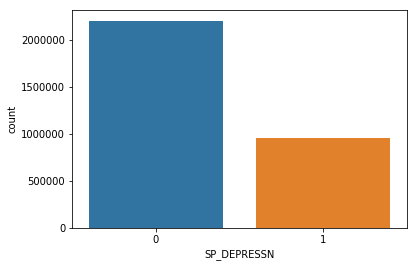

In [98]:
sns.countplot(x='SP_DEPRESSN', data=df_no_dup_records)

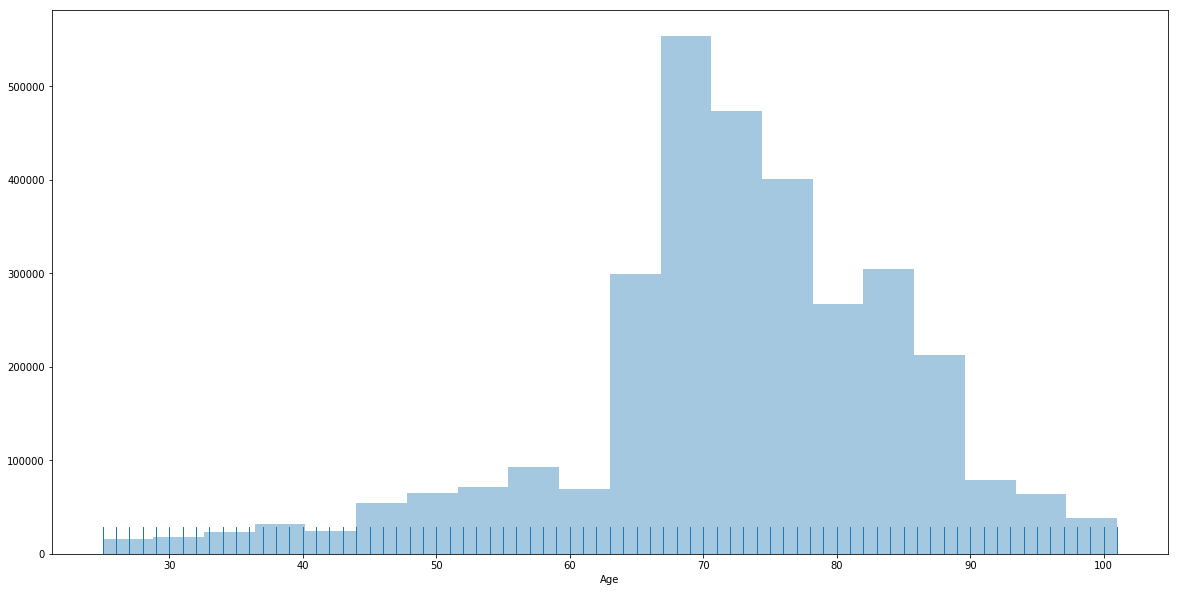

In [388]:
# Age
x=df_no_dup_records['Age']
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.distplot(x, bins=20, kde=False, rug=True,ax=ax);

In [ ]:
# State
sns.countplot(x='SP_STATE_CODE', data=df_no_dup_records)

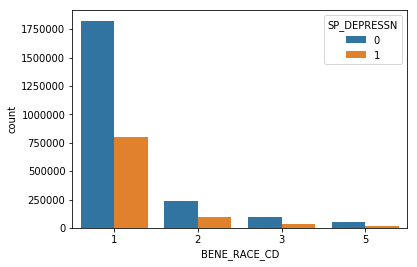

In [371]:
# Depression frequency for race catagory
#sns.catplot(x='BENE_RACE_CD', col='', kind='count', data=dataset)
#sns.countplot(data=df_no_dup_records,x='BENE_RACE_CD',hue='SP_DEPRESSN')

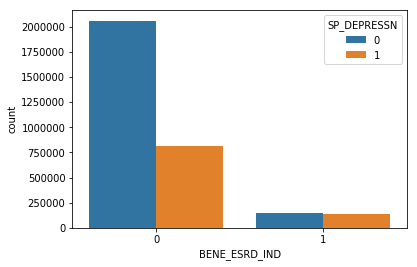

In [372]:
# End stage renal disease Indicator
# Chronic kidney disease (CKD) and ESRD result in poor quality of life and premature death. 
# ESRD is very costly to treat, such that nearly 25% of the Medicare budget is used to treat people with CKD and ESRD. 
# Diabetes is the most common cause of kidney failure.
# 0 = No, 1 = Yes
sns.countplot(data=df_no_dup_records,x='BENE_ESRD_IND',hue='SP_DEPRESSN')

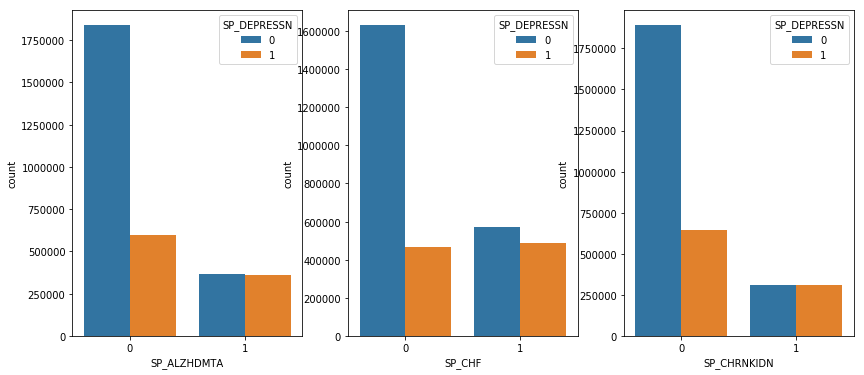

In [373]:
#g = sns.FacetGrid(df_no_dup_records, col="time")
#g.map(plt.hist, "tip");
pltdf=df_no_dup_records[['SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
        'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA',
       'SP_STRKETIA', 'SP_DEPRESSN']]

fig, ax =plt.subplots(1,3)
fig.set_size_inches(14, 6)
sns.countplot(data=df_no_dup_records,x='SP_ALZHDMTA',hue='SP_DEPRESSN',ax=ax[0])
sns.countplot(data=df_no_dup_records,x='SP_CHF',hue='SP_DEPRESSN',ax=ax[1])
sns.countplot(data=df_no_dup_records,x='SP_CHRNKIDN',hue='SP_DEPRESSN',ax=ax[2])

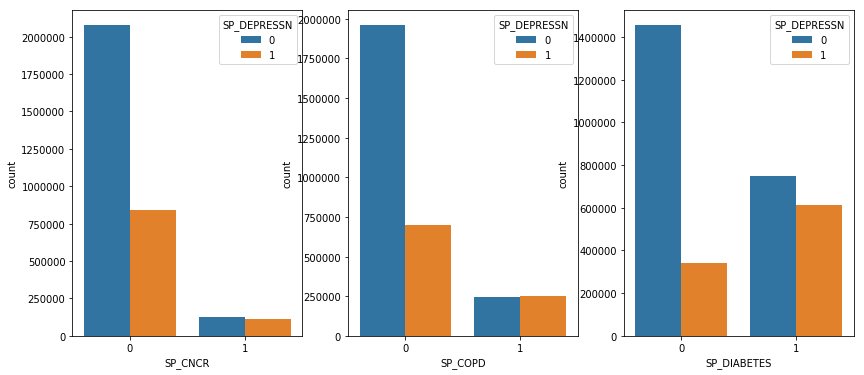

In [374]:
fig, ax =plt.subplots(1,3)
fig.set_size_inches(14, 6)
sns.countplot(data=df_no_dup_records,x='SP_CNCR',hue='SP_DEPRESSN',ax=ax[0])
sns.countplot(data=df_no_dup_records,x='SP_COPD',hue='SP_DEPRESSN',ax=ax[1])
sns.countplot(data=df_no_dup_records,x='SP_DIABETES',hue='SP_DEPRESSN',ax=ax[2])

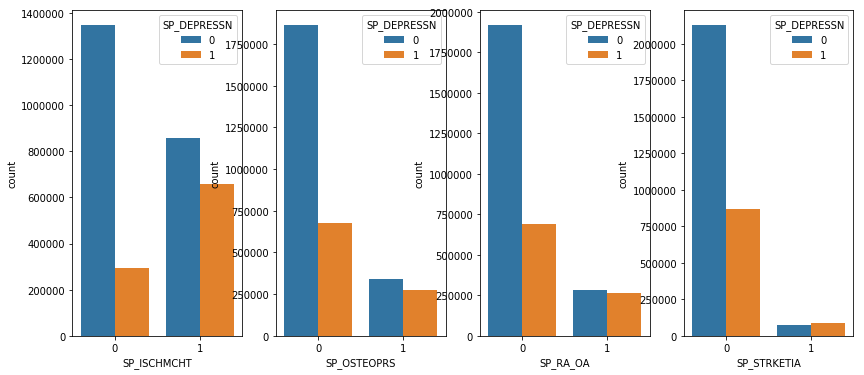

In [375]:
fig, ax =plt.subplots(1,4)
fig.set_size_inches(14, 6)
sns.countplot(data=df_no_dup_records,x='SP_ISCHMCHT',hue='SP_DEPRESSN',ax=ax[0])
sns.countplot(data=df_no_dup_records,x='SP_OSTEOPRS',hue='SP_DEPRESSN',ax=ax[1])
sns.countplot(data=df_no_dup_records,x='SP_RA_OA',hue='SP_DEPRESSN',ax=ax[2])
sns.countplot(data=df_no_dup_records,x='SP_STRKETIA',hue='SP_DEPRESSN',ax=ax[3])

# Applying Machine Learning Model

In [99]:
print(df_no_dup_records.columns)
df_no_dup_records.shape

Index(['DESYNPUF_ID', 'Year', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD',
       'BENE_RACE_CD_0', 'BENE_RACE_CD_1', 'BENE_RACE_CD_2', 'BENE_ESRD_IND',
       'SP_STATE_CODE', 'BENE_COUNTY_CD', 'SP_ALZHDMTA', 'SP_CHF',
       'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES',
       'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'Age'],
      dtype='object')


(3157153, 22)

In [105]:
X = df_no_dup_records.loc[:,['BENE_SEX_IDENT_CD',
       'BENE_RACE_CD_0', 'BENE_RACE_CD_1', 'BENE_RACE_CD_2', 'BENE_ESRD_IND', 'SP_ALZHDMTA', 'SP_CHF',
       'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DIABETES',
       'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA','Age']].values
y = df_no_dup_records.loc[:,'SP_DEPRESSN'].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=0)

In [106]:
# split data into train/test
#X = df_no_dup_records.iloc[:,[3,4,5,6,7,10,11,12,13,14,15,16,17,18,19,20,21]].values
#y = df_no_dup_records.iloc[:,15].values

#Splitting the data into Training Set and Test Set
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=0)

In [107]:
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.tree import DecisionTreeClassifier
#classifierObj= DecisionTreeClassifier(criterion='entropy')
classifierObj = DecisionTreeClassifier(criterion='gini', max_depth=10)
classifierObj.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [31]:
#Optimize model paramaters
# results before balancing depression {'criterion': 'gini', 'max_depth': 10} 0.7131452524811007
#grid_param= {  
#    'max_depth': [5, 10, 15, 20],
#    'criterion': ['gini', 'entropy']
#}
#from sklearn.model_selection import GridSearchCV
#gd_sr= GridSearchCV(estimator=classifierObj, param_grid=grid_param, cv=5, n_jobs=-1)
#gd_sr.fit(X_train, y_train) 
#print(gd_sr.best_params_) 
#print(gd_sr.best_score_)

In [32]:
#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies= cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('Acc: ', modelAccuracies.mean())
print('Std: ',modelAccuracies.std())

Acc:  0.7131461566499865
Std:  0.0006978678659407971


Confusion matrix:
 [[602103  58487]
 [213703  72853]]


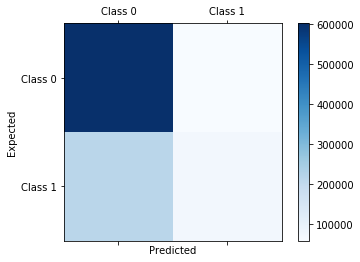

In [108]:
#Making predictions on the Test Set
y_pred = classifierObj.predict(X_test)

#Evaluating the predictions using a Confusion Matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [109]:
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('recall: {0:0.2f}'.format(recall))
print('precision: {0:0.2f}'.format(precision))

recall: 0.25
precision: 0.55


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.735


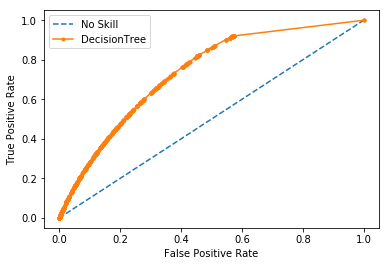

In [110]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = classifierObj.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='DecisionTree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.265


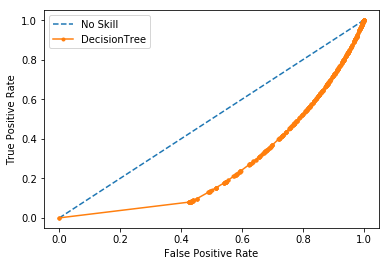

In [111]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = classifierObj.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 0]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='DecisionTree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

DecisionTree: f1=0.349 auc=0.502


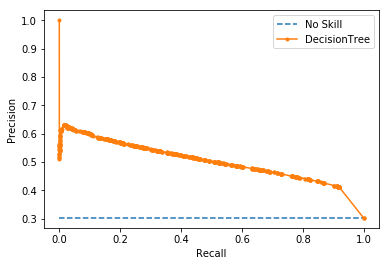

In [112]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# predict probabilities
lr_probs = classifierObj.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = classifierObj.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('DecisionTree: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='DecisionTree')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
from graphviz import Source
from sklearn import tree
feature_names = df_no_dup_records.columns[[3,4,5,6,7,10,11,12,13,14,16,17,18,19,20,21]]
print(class_names)
class_names = df_no_dup_records.columns[15]
Source( tree.export_graphviz(classifierObj, out_file=None, feature_names=feature_names, class_names=True))
graph = Source( tree.export_graphviz(classifierObj, out_file=None, feature_names=feature_names, class_names=True))
graph.format = 'png'
graph.render('dtree_render_unbalanced',view=True)
from IPython.display import SVG
graph = Source( tree.export_graphviz(classifierObj, out_file=None, feature_names=feature_names, class_names=True))
SVG(graph.pipe(format='svg'))

# Decision Tree with  Balanaced Classes
- good summary here to learn more [https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets]

In [113]:
# Class count
count_class_0, count_class_1 = df_no_dup_records.SP_DEPRESSN.value_counts()

# Divide by class
df_class_0 = df_no_dup_records[df_no_dup_records['SP_DEPRESSN'] == 0]
df_class_1 = df_no_dup_records[df_no_dup_records['SP_DEPRESSN'] == 1]

Random under-sampling:
1    954304
0    954304
Name: SP_DEPRESSN, dtype: int64


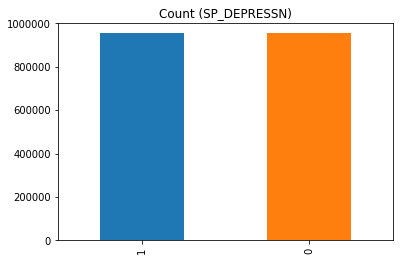

In [114]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.SP_DEPRESSN.value_counts())

df_test_under.SP_DEPRESSN.value_counts().plot(kind='bar', title='Count (SP_DEPRESSN)');

In [115]:
print(df_test_under.columns)
print(df_test_under.shape)

Index(['DESYNPUF_ID', 'Year', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD',
       'BENE_RACE_CD_0', 'BENE_RACE_CD_1', 'BENE_RACE_CD_2', 'BENE_ESRD_IND',
       'SP_STATE_CODE', 'BENE_COUNTY_CD', 'SP_ALZHDMTA', 'SP_CHF',
       'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES',
       'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'Age'],
      dtype='object')
(1908608, 22)


In [116]:
# split data into train/test
X_bal = df_test_under.loc[:,['BENE_SEX_IDENT_CD',
       'BENE_RACE_CD_0', 'BENE_RACE_CD_1', 'BENE_RACE_CD_2', 'BENE_ESRD_IND','SP_ALZHDMTA', 'SP_CHF',
       'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DIABETES',
       'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'Age']].values
y_bal = df_test_under.loc[:,'SP_DEPRESSN'].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_bal,y_bal,test_size=0.3,random_state=0)

In [117]:
#Optimize model paramaters
# results of this running this cell: {'criterion': 'entropy', 'max_depth': 10} 0.6824490559682641
#grid_param= {  
#    'max_depth': [5, 10, 15, 20],
#    'criterion': ['gini', 'entropy']
#}
#from sklearn.model_selection import GridSearchCV
#gd_sr= GridSearchCV(estimator=classifierObj, param_grid=grid_param, cv=5, n_jobs=-1)
#gd_sr.fit(X_train, y_train) 
#print(gd_sr.best_params_)
#print(gd_sr.best_score_)

In [118]:
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.tree import DecisionTreeClassifier
classifierObj2 = DecisionTreeClassifier(criterion='gini', max_depth=10)
classifierObj2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [445]:
#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies= cross_val_score(estimator=classifierObj3, X=X_train, y=y_train, cv=10)
print('Acc: ', modelAccuracies.mean())
print('Std: ',modelAccuracies.std())

Acc:  0.682451301706585
Std:  0.0007340078318537283


Confusion matrix:
 [[156216 130036]
 [ 51392 234939]]


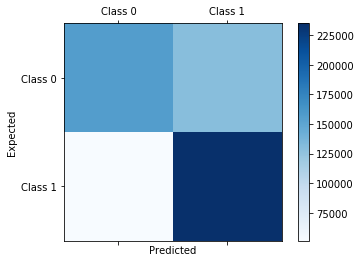

In [119]:
#Making predictions on the Test Set
y_pred = classifierObj2.predict(X_test)

#Evaluating the predictions using a Confusion Matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [120]:
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('recall: {0:0.2f}'.format(recall))
print('precision: {0:0.2f}'.format(precision))

recall: 0.82
precision: 0.64


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.736


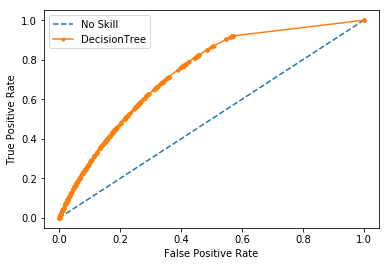

In [121]:
# now that classes are balanced, look at ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = classifierObj2.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='DecisionTree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.264


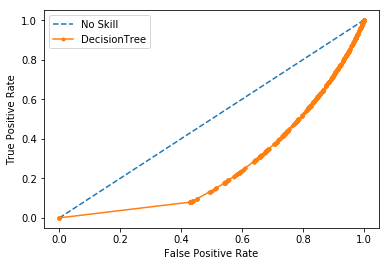

In [122]:
# ROC for 0 class
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = classifierObj2.predict_proba(X_test)
# keep probabilities for the negative outcome only
lr_probs = lr_probs[:, 0]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='DecisionTree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

DecisionTree: f1=0.721 auc=0.694


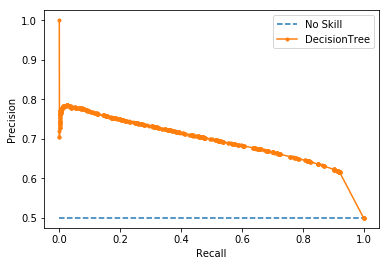

In [450]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# predict probabilities
lr_probs = classifierObj2.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = classifierObj2.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('DecisionTree: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='DecisionTree')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [451]:
from graphviz import Source
from sklearn import tree
feature_names = df_no_dup_records.columns[[3,4,5,6,7,10,11,12,13,14,16,17,18,19,20,21]]
class_names = df_no_dup_records.columns[15]
Source( tree.export_graphviz(classifierObj2, out_file=None, feature_names=feature_names, class_names=True))
graph = Source( tree.export_graphviz(classifierObj2, out_file=None, feature_names=feature_names, class_names=True))
graph.format = 'png'
graph.render('dtree_render_balanced',view=True)
from IPython.display import SVG
graph = Source( tree.export_graphviz(classifierObj2, out_file=None, feature_names=feature_names, class_names=True))
SVG(graph.pipe(format='svg'))